##### Copyright 2025 Google LLC.

In [ ]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

#### Developed by AI GDE [Nitin Tiwari](https://linkedin.com/in/tiwari-nitin).
* LinkedIn: [linkedin.com/in/tiwari-nitin](https://linkedin.com/in/tiwari-nitin)
* GitHub: [github.com/NSTiwari](https://github.com/NSTiwari)
* X: [@NSTiwari21](https://x.com/NSTiwari21)


This notebook demonstrates the vision understanding and multilingual capabilities of the Gemma 3 model by performing inference on images and videos.

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google-gemini/gemma-cookbook/blob/main/Gemma/[Gemma_3]Inference_images_and_videos.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

### Get access to Gemma 3

Before using Gemma 3 for the first time, you must request access to the model through Hugging Face by completing the following steps:

1. Log in to [Hugging Face](https://huggingface.co), or create a new Hugging Face account if you don't already have one.
2. Go to the [Gemma 3 model card](https://huggingface.co/google/gemma-3-4b-it) to get access to the model.
3. Complete the consent form and accept the terms and conditions.

To generate a Hugging Face token, open your [**Settings** page in Hugging Face](https://huggingface.co/settings), choose **Access Tokens** option in the left pane and click **New token**. In the next window that appears, give a name to your token and choose the type as **Write** to get the write access.

Then, in Colab, select **Secrets** (🔑) in the left pane and add your Hugging Face token. Store your Hugging Face token under the name `HF_TOKEN`.

### Select the runtime

To complete this tutorial, you'll need to have a Colab runtime with sufficient resources to load the Gemma 3 model. In this case, a T4/L4 GPU would be needed to load the model weights.

1. In the upper-right of the Colab window, click the **▾ (Additional connection options)** dropdown menu.
1. Select **Change runtime type**.
1. Under **Hardware accelerator**, select **T4 or L4**.

## Step 1: Install Transformers

In [ ]:
!pip install git+https://github.com/huggingface/transformers@v4.49.0-Gemma-3

## Step 2: Import libraries and dependencies


In [ ]:
from transformers import AutoProcessor, Gemma3ForConditionalGeneration
from PIL import Image
import cv2
from IPython.display import Markdown, HTML
from base64 import b64encode
import requests
import torch

## Step 3: Choose the Gemma 3 model variant.

Gemma 3 is available in four sizes, each supporting different features:

* `gemma-3-1b-it`
  * Supports only text input and English language
  * 32k context length

* `gemma-3-4b-it`, `gemma-3-12b-it`, `gemma-3-27b-it`
  * Supports both text and image input
  * Supports 140+ languages
  * 128k context length


In [ ]:
model_name = 'gemma-3-4b-it' # @param ['gemma-3-1b-it', 'gemma-3-4b-it', 'gemma-3-12b-it', 'gemma-3-27b-it']
model_id = f"google/{model_name}"

model = Gemma3ForConditionalGeneration.from_pretrained(
    model_id, device_map="auto", torch_dtype=torch.bfloat16,
).eval()

processor = AutoProcessor.from_pretrained(model_id)

## Step 4: Define helper functions

* `resize_image`: Resizes the input images to `n x n` pixels, ensuring the aspect ratio is preserved.

* `get_model_response`: Send a text prompt and an image to the model, and retrieve the model's response.

* `extract_frames`: Extracts a specified number of evenly spaced frames from a video file along with their timestamps.

* `show_video`: Embeds and displays a video in an HTML5 player.

In [21]:
def resize_image(image_path):
    img = Image.open(image_path)

    target_width, target_height = 640, 640
    # Calculate the target size (maximum width and height).
    if target_width and target_height:
        max_size = (target_width, target_height)
    elif target_width:
        max_size = (target_width, img.height)
    elif target_height:
        max_size = (img.width, target_height)

    img.thumbnail(max_size)

    return img


def get_model_response(img: Image, prompt: str, model, processor):
    # Prepare the messages for the model.
    messages = [
        {
            "role": "system",
            "content": [{"type": "text", "text": "You are a helpful assistant. Reply only with the answer to the question asked, and avoid using additional text in your response like 'here's the answer'."}]
        },
        {
            "role": "user",
            "content": [
                {"type": "image", "image": img},
                {"type": "text", "text": prompt}
            ]
        }
    ]

    # Tokenize inputs and prepare for the model.
    inputs = processor.apply_chat_template(
        messages, add_generation_prompt=True, tokenize=True,
        return_dict=True, return_tensors="pt"
    ).to(model.device, dtype=torch.bfloat16)

    input_len = inputs["input_ids"].shape[-1]

    # Generate response from the model.
    with torch.inference_mode():
        generation = model.generate(**inputs, max_new_tokens=100, do_sample=False)
        generation = generation[0][input_len:]

    # Decode the response.
    response = processor.decode(generation, skip_special_tokens=True)
    return response


def extract_frames(video_path, num_frames):
    """
    The function is adapted from:
    https://github.com/merveenoyan/smol-vision/blob/main/Gemma_3_for_Video_Understanding.ipynb
    """
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error: Could not open video file.")
        return []

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    # Calculate the step size to evenly distribute frames across the video.
    step = total_frames // num_frames
    frames = []

    for i in range(num_frames):
        frame_idx = i * step
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = cap.read()
        if not ret:
            break
        img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        timestamp = round(frame_idx / fps, 2)
        frames.append((img, timestamp))

    cap.release()
    return frames


def show_video(video_path, video_width = 600):
  video_file = open(video_path, "r+b").read()
  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  video_html = f"""<video width={video_width} controls><source src="{video_url}"></video>"""
  return HTML(video_html)

## Step 5: Inference on images
Fetch some sample images for inferencing.

In [ ]:
!wget https://raw.githubusercontent.com/NSTiwari/Inference-Gemma-3/main/assets/image_1.png -O /content/image_1.png
!wget https://raw.githubusercontent.com/NSTiwari/Inference-Gemma-3/main/assets/image_2.png -O /content/image_2.png
!wget https://raw.githubusercontent.com/NSTiwari/Inference-Gemma-3/main/assets/image_3.png -O /content/image_3.png
!wget https://raw.githubusercontent.com/NSTiwari/Inference-Gemma-3/main/assets/image_4.png -O /content/image_4.png

#### Example 1: Describe an image

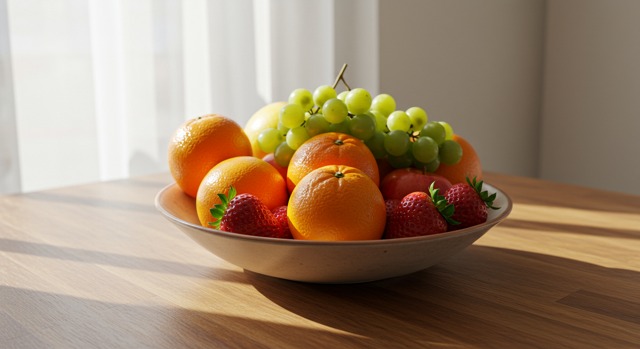

A bowl filled with oranges, grapes, and strawberries on a wooden table.

In [ ]:
image_file = 'image_1.png' # @param {type: 'string'}
prompt = "Describe the image." # @param {type: 'string'}


img = resize_image(image_file)
display(img)
response = get_model_response(img, prompt, model, processor)
display(Markdown(response))

#### Example 2: Identify landmark

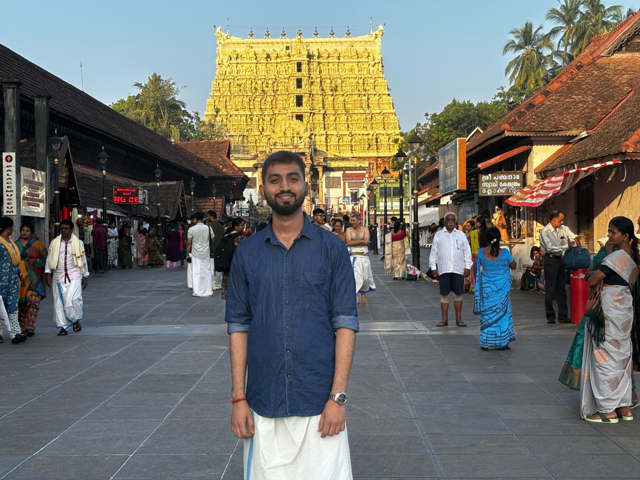

Thiruvananthapuram, Kerala, India - Sri Padmanabhaswamy Temple

In [ ]:
image_file = 'image_2.png' # @param {type: 'string'}
prompt = "Identify the famous landmark and location." # @param {type: 'string'}


img = resize_image(image_file)
display(img)
response = get_model_response(img, prompt, model, processor)
display(Markdown(response))

#### Example 3: Multilingual prompt

> The prompt is in Hindi language which translates to: "What's present in this image?"

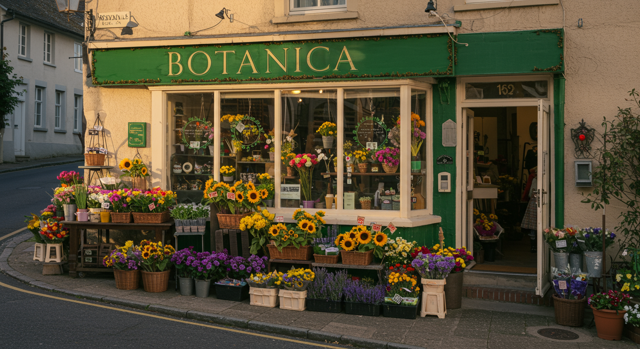

एक फूल की दुकान

In [ ]:
image_file = 'image_3.png' # @param {type: 'string'}
prompt = "इस चित्र में क्या है? " # @param {type: 'string'}


img = resize_image(image_file)
display(img)
response = get_model_response(img, prompt, model, processor)
display(Markdown(response))

> The output "एक फूल की दुकान" translates to A flower shop.

#### Example 4: Mathematical Reasoning

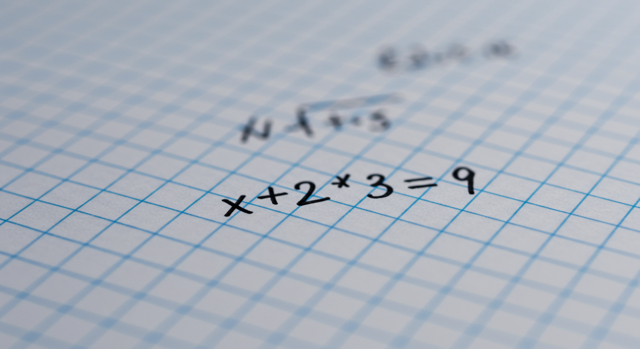

x = 3

In [ ]:
from PIL import Image
from IPython.display import Markdown

image_file = 'image_4.png' # @param {type: 'string'}
prompt = "What is the value of x?" # @param {type: 'string'}


img = resize_image(image_file)
display(img)
response = get_model_response(img, prompt, model, processor)
display(Markdown(response))

## Step 6: Inference on videos

Download a sample video.

The video is a clip from the movie "The Godfather".
* Credits: Paramount Movies
* Source: [YouTube](https://www.youtube.com/watch?v=eZHsmb4ezEk)

In [ ]:
!wget https://raw.githubusercontent.com/NSTiwari/Inference-Gemma-3/main/assets/video.mp4 -O /content/video.mp4
!mkdir -p /content/frames

In [ ]:
# Video file.
video_path = "video.mp4" # @param {type : 'string'}

# No. of frames to be extracted from the video.
num_frames = 10 # @param {type : 'integer'}

In [ ]:
video_output = show_video(video_path, video_width=800)
display(video_output)

In [15]:
video_frames = extract_frames(video_path, num_frames=num_frames)

messages = [
    {
        "role": "system",
        "content": [{"type": "text", "text": "You are a helpful assistant."}]
    },
    {
        "role": "user",
        "content": [{"type": "text", "text": "Please summarize what is happening in this video."}]
    }
]


# Add frames to the messages structure.
for frame_data in video_frames:
    img, timestamp = frame_data
    messages[1]["content"].append({"type": "text", "text": f"Frame at {timestamp} seconds:"})
    img.save(f"/content/frames/frame_{timestamp}.png")
    messages[1]["content"].append({"type": "image", "url": f"/content/frames/frame_{timestamp}.png"})


inputs = processor.apply_chat_template(
    messages, add_generation_prompt=True, tokenize=True,
    return_dict=True, return_tensors="pt"
).to(model.device)


input_length = inputs["input_ids"].shape[-1]

# Generate a response based on the inputs.
output = model.generate(**inputs, max_new_tokens=500, do_sample=False)
output = output[0][input_length:]
response = processor.decode(output, skip_special_tokens=True)

display(Markdown(response))

Okay, here's a summary of what's happening in the video, based on the frames you've provided:

The video appears to be a scene from *The Godfather*. It depicts Don Vito Corleone in his office, which is dimly lit and has a very serious, almost intimidating atmosphere. 

Here's a breakdown of the key moments:

*   **Initial Scene (0.0 - 8.42 seconds):** Don Corleone is seated at his desk, seemingly in a meeting or receiving a visitor. He's calm and composed, observing the situation.
*   **Discussion (8.42 - 16.83 seconds):**  He continues to observe, possibly listening to a report or a request.
*   **Offering (16.83 - 25.25 seconds):** He is handing something to someone, likely a document or a small gift.
*   **Intense Moment (25.25 - 33.67 seconds):** The scene shifts to a close-up of Don Corleone, suggesting a moment of contemplation or decision-making.
*   **Presence of Others (33.67 - 42.08 seconds):** Other men are present in the room, likely associates or subordinates, adding to the sense of power and authority.
*   **Continued Observation (42.08 - 50.5 seconds):** Don Corleone remains seated, observing the room and the people within it.
*   **Conversation (50.5 - 58.92 seconds):** He is engaged in a conversation with someone, likely discussing business or matters of importance.
*   **Final Interaction (58.92 - 75.75 seconds):**  He is speaking with another man, possibly giving instructions or offering advice.

**Overall Impression:** The video captures a classic scene from *The Godfather* – a powerful and enigmatic Don Corleone in his office, engaged in a serious and potentially dangerous conversation. It’s a scene filled with tension, power, and unspoken threats.

Do you want me to focus on a specific aspect of the video, or perhaps describe a particular detail in more detail?

Congratulations on successfully completing this tutorial.